In [2]:
import tensorflow as tf
import cv2
import os

In [3]:
import numpy as np

In [4]:
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#### Testing

In [193]:
cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    if ret:
        # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
        gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
        # a=0,b=0,c=0,d=0
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
            # a=x,b=y,c=w,d=h
        cv2.imshow("test",frame[140:500,50:400])
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


In [190]:
cap.release()

In [5]:
#creating tf data pipeline
images=tf.data.Dataset.from_tensor_slices(tf.io.gfile.glob("images/*.jpg")[:700])

In [6]:
len(images)

700

In [6]:
# images=images.take(round(len(images)*.5))

In [7]:
images

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
# len(images)

In [9]:
images.as_numpy_iterator().next()

b'images\\Aaron_Eckhart_0001.jpg'

In [8]:
#preprocessing image
def load_image(x):
    byte_image=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_image)
    img=tf.image.resize(img,(200,200))
    img=img/255.0
    return img

In [176]:
data=tf.data.Dataset.zip((images,tf.data.Dataset.from_tensor_slices(tf.ones(len(images)))))

In [10]:
data

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
sample=data.as_numpy_iterator().next()

In [13]:
sample

(b'images\\Aaron_Eckhart_0001.jpg', 1.0)

In [11]:
def preprocess(image,label):
    return(load_image(image),label)

In [15]:
res=preprocess(*sample)

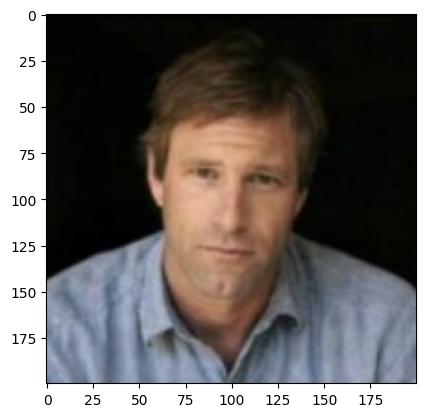

In [16]:
import matplotlib.pyplot as plt
plt.imshow(res[0])

In [177]:
#build dataloader pipeline
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=100)
# data=data.batch(16)
# data=data.prefetch(8)

In [178]:
train=data.take(round(len(data)*.8))
train=train.batch(16)
train=train.prefetch(8)

In [179]:
val=data.skip(round(len(data)*.8))
val=data.take(round(len(data)*.2))
val=val.batch(16)
val=val.prefetch(8)

In [165]:
train,val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### building Feature Extractor model

In [72]:
from tensorflow.keras.layers import Conv2D,Layer,Input,Dense,MaxPooling2D,Flatten,Concatenate,Normalization
from tensorflow.keras.models import Model

In [166]:
def FeatureExtractor():
    i=Input(shape=(200,200,3))
    c1=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding="same",activation="relu")(i)
    m1=MaxPooling2D(64,strides=(2,2),padding="same")(c1)

    c3=Conv2D(32,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(m1)
    m3=MaxPooling2D(32,strides=(2,2),padding="same")(c3)

    f=Flatten()(m3)
    
    x=Dense(64,activation='relu',name="img_features")(f)

    return [i,x,Model(inputs=i,outputs=x)]

In [167]:
def EuclideanDistance(feature1,feature2):
    return np.linalg.norm(feature1 - feature2)

In [168]:
def addLastLayer():
    i,fully_connected,_=FeatureExtractor()
    x=Dense(1,activation="sigmoid")(fully_connected)
    final_model=Model(inputs=[i],outputs=[x,fully_connected])
    final_model.build(input_shape=(200,200,3))
    return final_model

In [169]:
final_model=addLastLayer()

In [170]:
final_model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 100, 100, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 25, 25, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ img_features (Dense)                 │ (None, 64)                  │         346,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,177 (1.43 MB)

 Trainable params: 374,177 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# i=Input(shape=(200,200,3))
# c1=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding="same",activation="relu")(i)
# # n1=Normalization()(c1)
# m1=MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")(c1)

# # c2=Conv2D(64,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(m1)
# # m2=MaxPooling2D(64,strides=(2,2),padding="same")(c2)

# c3=Conv2D(32,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(m1)
# # n2=Normalization()(c3)
# m3=MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")(c3)

# # n3=Normalization()(m3)
# f=Flatten()(m3)
# # known=Dense(num_classes,activation="softmax")(f)
# # unknown=Dense(1,activation="sigmoid")(f)

# # x=Concatenate(axis=-1)([known,unknown])

# features=Dense(64,activation='relu',name="feature")(f)
# # x=Dense(1,activation='sigmoid')(x)
# x=Dense(1,activation="sigmoid")(features)
# model=Model(inputs=[i],outputs=[x])

In [79]:
# model.summary()

In [171]:
loss=tf.keras.losses.BinaryCrossentropy()
accuracy=tf.keras.metrics.binary_accuracy
opt=tf.keras.optimizers.Adam(learning_rate=0.05)

In [172]:
class Attendance(Model):
    def __init__(self,model,**kwargs):
        super().__init__(**kwargs)
        self.model=model
        
    def compile(self,opt,loss,**kwargs):
        super().compile(**kwargs)
        self.loss=loss
        self.opt=opt
    
    def train_step(self,batch,**kwargs):
        X,y=batch

        with tf.GradientTape() as tape:
            yhat=self.model(X,training=True)
            classLoss=self.loss(y,yhat[0])
            grad=tape.gradient(classLoss,self.model.trainable_variables)
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        
        acc=accuracy(y,yhat[0])
        return {"loss":classLoss,"accuracy":acc}
    
    def test_step(self,batch,**kwargs):
        X,y=batch
        
        yhat=self.model(X,training=False)
        classLoss=self.loss(y,yhat[0])
        
        acc=accuracy(y,yhat[0])
        return {"loss":classLoss,"accuracy":acc}
    
    def get_config(self):
        base_config = super().get_config()
        config = {
                "submodel": tf.keras.utils.serialize_keras_object(self.model),
                }
        return {**base_config, **config}
    @classmethod
    def from_config(cls, config):
        submodel_config = config.pop("submodel")
        submodel = tf.keras.utils.deserialize_keras_object(submodel_config)
        return cls(model=submodel, **config)
    
    def call(self,X,**kwargs):
        return self.model(X,**kwargs)

In [173]:
model=Attendance(final_model)

In [174]:
model.compile(opt,loss)

In [180]:
hist=model.fit(train,epochs=5,validation_data=val)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [181]:
model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[array([[1.]], dtype=float32),
 array([[1.3967139e+02, 2.3081892e+06, 1.7356112e+03, 0.0000000e+00,
         2.3177782e+06, 2.3067208e+06, 1.6446989e+03, 0.0000000e+00,
         7.5076416e+02, 0.0000000e+00, 0.0000000e+00, 2.3019582e+06,
         2.2417520e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         2.0043824e+03, 0.0000000e+00, 2.3089998e+06, 2.3099182e+06,
         0.0000000e+00, 1.9838102e+03, 0.0000000e+00, 2.2998148e+06,
         2.2829818e+06, 2.2687492e+06, 1.0309475e+03, 2.3139138e+06,
         7.4205652e+02, 0.0000000e+00, 0.0000000e+00, 1.8324707e+01,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3100958e+06,
         0.0000000e+00, 0.0000000e+00, 2.3968066e+03, 2.6457549e+03,
         2.2869460e+06, 2.2857098e+06, 2.3097108e+06, 2.3126775e+06,
         0.0000000e+00, 1.2846449e+03, 2.1404568e+06, 2.2463632e+06,
         2.3038890e+06, 1.1822578e+03, 0.0000000e+00, 0.0000000e+00,
         5.0249860e+02, 6.5469153e+02, 0.0000000e+00, 0.0000000e+00,
   

##### zero loss,val_loss and 1 accuracy is because every image being passed has an image and hence the label will always be 1, there is no image which has label 0 and hence the loss and accuracy are 0 and 1

In [91]:
# model.save("AttendanceSystem.keras")
# model.save_weights("model_weights.h5")

In [184]:
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'Attendance': Attendance}):
    # custom_objects = {'Attendance': Attendance.from_config}
    # custom_objects={'Functional':tf.keras.models.Model}
    model=tf.keras.models.load_model("AttendanceSystem.keras")

In [185]:
model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[array([[1.]], dtype=float32),
 array([[1.4758671e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.7411255e+06, 0.0000000e+00,
         1.7435232e+06, 1.7301802e+06, 2.9163422e+02, 0.0000000e+00,
         1.7391462e+06, 0.0000000e+00, 1.7464792e+06, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.5326056e+02,
         1.7444038e+06, 0.0000000e+00, 0.0000000e+00, 1.5556751e+06,
         2.0535303e+03, 1.7369848e+06, 2.0086268e+03, 1.8920579e+03,
         0.0000000e+00, 1.6858732e+06, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7308192e+06, 1.7364232e+06, 0.0000000e+00,
         3.0100273e+03, 0.0000000e+00, 2.5681541e+03, 1.7372958e+06,
         0.0000000e+00, 1.1993213e+02, 0.0000000e+00, 0.0000000e+00,
         4.2356824e+02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
   

### Manual Testing

In [64]:

# features_extracted=output[-1]

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1f168188ee0>

In [244]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [86]:
test_img=os.path.join("images","Zinedine_Zidane_0001.jpg")

In [87]:
test_img

'images\\Zinedine_Zidane_0001.jpg'

In [88]:
test_img=load_image(test_img)

In [89]:
test_img=np.expand_dims(test_img,axis=0)

In [122]:
# test_img

In [186]:
feature1=model.predict(test_img)[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [187]:
feature2=model.predict(np.expand_dims(load_image(os.path.join("images","Zach_Parise_0001.jpg")),axis=0))[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [825]:
person_feature={}

In [188]:
dist1=EuclideanDistance(feature1,feature2)

In [191]:
dist2=EuclideanDistance(feature1,model.predict(np.expand_dims(load_image(os.path.join("images","Zinedine_Zidane_0003.jpg")),axis=0))[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [192]:
dist1,dist2

(1738266.9, 160871.7)

In [193]:
dist2<dist1

True

In [846]:
person_feature["Zach_Parise_0001"]=EuclideanDistance(feature1,feature2)

In [847]:
len(person_feature)

6

In [848]:
min_distance=min(person_feature.values())

In [851]:
person_feature.values()

dict_values([318251.4, 477340.8, 1943809.6, 854507.2, 1962109.6, 2332049.2])

In [849]:
min_distance

318251.4

In [850]:
for key in list(person_feature.keys()):
    if person_feature[key]==min_distance:
        print(key)
        break

Zinedine_Zidane_0002


In [852]:
person_feature.keys()

dict_keys(['Zinedine_Zidane_0002', 'Zydrunas_Ilgauskas_0001', 'Zoe_Ball_0001', 'Zico_0001', 'Yuri_Malenchenko_0001', 'Zach_Parise_0001'])

### Realtime Comparison

In [194]:
def isFace(gray,frame):
    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
    if len(faces)>0:
        return (True,faces)
    else:
        return(False,faces)

In [195]:
def NewFace():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                # print(coord)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('c'):
                    name=input("Enter name: ")
                    print("processing..")
                    imgpath=os.path.join("user_imgs",name+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    frame=np.expand_dims(load_image(imgpath),axis=0)
                    features=model.predict(frame)[1]
                    np.save("features/"+name+".npy",features)
                    print("done")
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e,frame.shape)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [197]:
NewFace()

Enter name:  Arnav


processing..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
done


In [198]:
feature_test=np.load("features/Arnav.npy")

In [199]:
feature_test

array([[1.1021468e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.3048932e+06, 0.0000000e+00,
        1.3065952e+06, 1.2964868e+06, 2.2819275e+02, 0.0000000e+00,
        1.3031159e+06, 0.0000000e+00, 1.3087492e+06, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.2621640e+02,
        1.3072448e+06, 0.0000000e+00, 0.0000000e+00, 1.1632452e+06,
        1.5850239e+03, 1.3016191e+06, 1.5276125e+03, 1.4288857e+03,
        0.0000000e+00, 1.2625732e+06, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.2969054e+06, 1.3010538e+06, 0.0000000e+00,
        2.3237104e+03, 0.0000000e+00, 1.6237332e+03, 1.3017048e+06,
        0.0000000e+00, 2.1522772e+02, 0.0000000e+00, 0.0000000e+00,
        3.4829779e+02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.2731520e+06, 0.0000000e+00, 1.1922192e

In [196]:
def SameFaceCheck():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('a'):
                    print("processing..")
                    imgpath=os.path.join("user_imgs","temp"+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    img=np.expand_dims(load_image(imgpath),axis=0)
                    new=model.predict(img)[1]
                    person_feature={}
                    for feature in os.listdir("features"):
                        present=np.load("features/"+feature)
                        distance=EuclideanDistance(present,new)
                        person_feature[distance]=feature
                    min_dist=min(person_feature.keys())
                    print(person_feature[min_dist][:-4])
                    os.remove(os.path.join("user_imgs","temp.jpg"))
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [200]:
SameFaceCheck()

processing..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Arnav
